# Imports

In [12]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters and constants

In [7]:
camels_spat_attrs_dir = Path('../../../../../gladwell/hydrology/SUMMA/summa-ml-models/CAMELS_spat_NH')

camels_spat_attrs_file = camels_spat_attrs_dir / ('camels_spat_attributes.csv')
camels_spat_attrs_file_to_nh = camels_spat_attrs_dir / ('camels_spat_attributes_to_nh.csv')

attributes_dict_found = [
    'prec_mean',
    'pet_mean',
    'aridity1_mean',
    'seasonality1_mean',
    'fracsnow1_mean',
    'high_prec_freq',
    'high_prec_dur_mean',
    'low_prec_freq ',
    'low_prec_dur_mean',
    'elev_mean',
    'slope_mean',
    'basin_area',
    'soil_thickness_mean',
    'porosity_mean', 
    'log_permeability_mean',
]

attributes_dict_computed = [
    'lai_mean_month_max',
    'lai_mean_month_diff',
    'sand_layer',
    'silt_layer',
    'clay_layer',

    # forest_frac          --> lc2_mixed_forest_fractio (???). No -> Select either lc1_ or lc2, 
    # and find the ratio of forest pixels to all pixels per basin

    # soil_conductivity    --> Maybe use log_permeability_mean as a proxy or convert to 
    # conductivity somehow (https://en.wikipedia.org/wiki/Permeability_(materials_science)#Relation_to_hydraulic_conductivity)
]

# Functions

In [8]:
# Function to rename columns based on the provided rules
def rename_columns(col):
    if col.startswith('CAN'):
        # Remove prefix and pad the remaining part to 7 places with trailing zeros
        new_col = col[4:].ljust(7, '0')
        return new_col
    elif col.startswith('USA'):
        # Remove prefix and pad the remaining part to 8 places with trailing zeros
        new_col = col[4:].ljust(8, '0')
        return new_col
    else:
        return col
    
def compute_lai_mean_month_max_diff(attrs_df, attrs_df_nh):
    # Filter the rows related to lai_mean_month
    lai_mean_month_rows = attrs_df[attrs_df['Attribute'].str.contains('lai_mean_month_')].copy()

    # Convert the values to numeric
    lai_mean_month_rows.iloc[:, 1:] = lai_mean_month_rows.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
    
    # Compute the maximum and minimum values among the months for each column
    lai_mean_month_max = lai_mean_month_rows.iloc[:, 1:].max()
    lai_mean_month_min = lai_mean_month_rows.iloc[:, 1:].min()
    
    # Compute the difference between the max and min values
    lai_mean_month_diff = lai_mean_month_max - lai_mean_month_min
    
    # Create new rows for lai_mean_month_max and lai_mean_month_diff
    lai_mean_month_max_row = pd.DataFrame([['lai_mean_month_max'] + lai_mean_month_max.tolist()],
                                          columns=attrs_df.columns)
    lai_mean_month_diff_row = pd.DataFrame([['lai_mean_month_diff'] + lai_mean_month_diff.tolist()],
                                           columns=attrs_df.columns)
    
    # Append the new rows to attrs_df_nh
    attrs_df_nh = pd.concat([attrs_df_nh, lai_mean_month_max_row, lai_mean_month_diff_row], ignore_index=True)
    
    return attrs_df_nh
    
def compute_fraction_mean(attrs_df, attrs_df_nh, fraction_type):
    # Identify rows that match the pattern for the specified fraction type
    fraction_rows = attrs_df[attrs_df['Attribute'].str.contains(fr'{fraction_type}_\d+-\d+cm_mean')].copy()
    
    # Ensure we have identified rows
    if fraction_rows.empty:
        print(f"No matching {fraction_type} fraction rows found.")
        return attrs_df_nh
    
    # Convert the values to numeric, handling non-numeric values gracefully
    for col in fraction_rows.columns[1:]:
        fraction_rows[col] = pd.to_numeric(fraction_rows[col], errors='coerce')
   
    # Convert the values from fractional representation to percentages (e.g., 800 to 80%)
    fraction_rows.iloc[:, 1:] = fraction_rows.iloc[:, 1:] / 10.0
    
    # Drop rows where all values are NaN
    fraction_rows.dropna(how='all', subset=fraction_rows.columns[1:], inplace=True)
    
    # Ensure there are valid rows to process
    if fraction_rows.empty:
        print(f"No valid {fraction_type} fraction values after conversion.")
        return attrs_df_nh
    
    # Compute the mean value for each column
    fraction_means = fraction_rows.iloc[:, 1:].mean()

    # Check if all values in fraction_means are NaN
    if fraction_means.isna().all():
        print(f"Computed {fraction_type}_mean is NaN.")
        return attrs_df_nh

    # Create a new row with the computed mean values for each column
    new_row = pd.DataFrame([[f'{fraction_type}_layer_mean'] + fraction_means.tolist()],
                           columns=['Attribute'] + fraction_means.index.tolist())
    
    # Append the new row to attrs_df_nh
    attrs_df_nh = pd.concat([attrs_df_nh, new_row], ignore_index=True)
    
    return attrs_df_nh

# Load attributes file

In [36]:
# Read the CSV file, specifying dtype as string to avoid mixed types warning
attrs_df = pd.read_csv(camels_spat_attrs_file, dtype=str)

# display(
#     attrs_df.shape,
#     attrs_df.head()
# )

# Only keep the columns 'Attribute' and the ones with a pattern ABC_code like CAN_01AD002 or USA_14306500
attrs_df = attrs_df.filter(regex='Attribute|^[A-Z]{3}_[0-9A-Z]+$').copy()

# display(
#     attrs_df.shape,
#     attrs_df.head()
# )

# Apply the rename function to the columns
attrs_df.rename(columns=rename_columns, inplace=True)

# Filter by column 'Attribute' values to be in attributes_dict_found
attrs_df_nh = attrs_df[attrs_df['Attribute'].isin(attributes_dict_found)].copy()

# Compute and add the rows for the computed attributes
# 'lai_mean_month_max' and 'lai_mean_month_diff' are computed from the 'lai_mean_month_XX' rows
attrs_df_nh = compute_lai_mean_month_max_diff(attrs_df, attrs_df_nh)

# 'sand_frac', 'silt_frac', and 'clay_frac' are computed from the 'TYPE_XX-YYcm_mean' rows
attrs_df_nh = compute_fraction_mean(attrs_df, attrs_df_nh, 'sand')
attrs_df_nh = compute_fraction_mean(attrs_df, attrs_df_nh, 'silt')
attrs_df_nh = compute_fraction_mean(attrs_df, attrs_df_nh, 'clay')

display(
    attrs_df_nh.shape,
    attrs_df_nh.head()
)

(19, 1635)

,Attribute,01AD002,01AD003,01AE001,01AF007,01AF009,01AJ003,01AJ004,01AJ010,01AK001,...,14303200,14305500,14306340,14306500,14308990,14309500,14316700,14325000,14362250,14400000
0,aridity1_mean,0.18798583750094697,0.17771905684226516,0.31516898447471303,0.421913933668009,0.12263759217704563,0.41848074525432577,0.6724836199320753,0.30651026635169837,0.043428235820958824,...,0.43177476151658767,0.021250218474997425,0.47052164944431496,0.16032102901412718,0.4650637376108359,0.004136225478121908,0.23315401880713255,-0.005607113418416518,1.3813068482275603,0.5281426570417664
1,fracsnow1_mean,0.2756233080498433,0.2894199021283202,0.2555185982980571,0.24524128909027543,0.2690464221134831,0.224942017134205,0.2301874059863953,0.22689452145074407,0.21377429424346422,...,0.026315403460529307,0.012226889694837659,0.011611662502016907,0.010262657582588416,0.05090024210364673,0.0581173905850098,0.15202128002119514,0.027193922852899996,0.04256914814163236,0.019044030812879927
2,seasonality1_mean,0.15468573009104025,0.16851650097590484,0.1476173286789044,0.14515365834232732,0.13456896062270401,0.06395003612785412,0.10101936975856568,0.04760639402986577,0.016672196062911922,...,-0.8241268738090196,-0.8483668072099655,-0.8417459985628054,-0.8726288407905065,-0.8149220320888674,-0.9188400456171943,-0.7678638062615898,-0.9384284575663833,-0.8143255035207517,-0.9760095115616989
3,low_prec_dur_mean,2.693663292088489,2.7707018195321202,2.8450272479564034,2.812354988399072,2.793576017130621,2.9692154915590865,2.9163433559650827,2.884466556108347,3.0145220588235295,...,4.928952042628774,4.867534942820838,5.391116594694633,5.207293035479632,5.824688115561392,5.575639204545454,4.798497267759563,5.612433862433862,5.62764705882353,6.303641732283465
4,high_prec_freq,15.857452966714906,16.366039409246905,17.25731887110362,16.891807035295518,16.580279077982865,18.68471151896167,18.23613669172184,18.333333333333336,18.98647939091625,...,16.640733590733593,17.233038292765254,18.948385398385398,18.42483028916476,19.946314932662425,19.89531914024191,16.39427943250643,20.068681318681318,20.256054756054755,22.226702138650687


## Format and save new attribute file

In [10]:
# Transpose the DataFrame
attrs_df_nhT = attrs_df_nh.transpose().copy()

# Set the first row as the header
attrs_df_nhT.columns = attrs_df_nhT.iloc[0]
attrs_df_nhT = attrs_df_nhT[1:]

# Reset the index to make 'Attribute' a column again
attrs_df_nhT.reset_index(inplace=True)

# Rename 'index' to 'basin'
attrs_df_nhT.rename(columns={attrs_df_nhT.columns[0]: 'basin'}, inplace=True)

# Save the final DataFrame to a CSV file
attrs_df_nhT.to_csv(camels_spat_attrs_file_to_nh, index=False)

print(attrs_df_nhT.columns)

# Display the final DataFrame
display(attrs_df_nhT)

Index(['basin', 'aridity1_mean', 'fracsnow1_mean', 'seasonality1_mean',
       'low_prec_dur_mean', 'high_prec_freq', 'high_prec_dur_mean',
       'prec_mean', 'pet_mean', 'basin_area', 'elev_mean', 'slope_mean',
       'soil_thickness_mean', 'porosity_mean', 'log_permeability_mean',
       'lai_mean_month_max', 'lai_mean_month_diff', 'sand_layer_mean',
       'silt_layer_mean', 'clay_layer_mean'],
      dtype='object', name='Attribute')


Attribute,basin,aridity1_mean,fracsnow1_mean,seasonality1_mean,low_prec_dur_mean,high_prec_freq,high_prec_dur_mean,prec_mean,pet_mean,basin_area,elev_mean,slope_mean,soil_thickness_mean,porosity_mean,log_permeability_mean,lai_mean_month_max,lai_mean_month_diff,sand_layer_mean,silt_layer_mean,clay_layer_mean
0,01AD002,0.18798583750094697,0.2756233080498433,0.15468573009104025,2.693663292088489,15.857452966714906,1.0893032384690873,1080.056879631484,233.75525736030443,14691.61894,362.03506767343833,4.029331134624624,0.7809965276359849,0.1331932769477868,-14.37731088910784,4.476095,4.058043,39.032694,27.675981,14.716443
1,01AD003,0.17771905684226516,0.2894199021283202,0.16851650097590484,2.7707018195321202,16.366039409246905,1.1108986615678775,1095.7515151515152,227.5035173160173,1343.736223,353.94557528636614,5.309244119201183,0.7881686573002401,0.1607692298264457,-14.657692212324877,4.683582,4.393957,32.331455,28.878228,17.072509
2,01AE001,0.31516898447471303,0.2555185982980571,0.1476173286789044,2.8450272479564034,17.25731887110362,1.1016393442622952,1010.4347371174471,239.5193238294533,2249.524543,276.4003361537538,4.708683230092109,0.6957798995914186,0.1580769221226755,-14.707692219660832,4.237068,3.900777,29.837864,31.546744,15.110833
3,01AF007,0.421913933668009,0.24524128909027543,0.14515365834232732,2.812354988399072,16.891807035295518,1.0959097320169253,1070.9710144927535,233.81368885869566,323.8344727,267.085233314709,3.614874795562039,0.7370588078218347,0.1574999978765842,-14.349999904632568,4.474721,4.123323,26.809677,31.412054,20.29823
4,01AF009,0.12263759217704563,0.2690464221134831,0.13456896062270401,2.793576017130621,16.580279077982865,1.1053763440860216,1102.198113207547,227.16194968553458,183.6754339,337.75361356232406,6.686667928116752,0.6857232627628734,0.189999997615814,-15.199999809265137,4.886292,4.595422,27.616713,29.495778,19.319038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,14309500,0.004136225478121908,0.0581173905850098,-0.9188400456171943,5.575639204545454,19.89531914024191,1.4031578947368422,1640.6544943820224,363.3109857794944,225.9326068,739.8640906806634,20.123505046005175,0.6259550458929511,0.1538461529864714,-14.28461529658391,4.182288,2.671913,25.312107,28.414839,23.543059
1630,14316700,0.23315401880713255,0.15202128002119514,-0.7678638062615898,4.798497267759563,16.39427943250643,1.2942583732057416,1592.4171122994653,349.9737967914439,587.6714412,942.100099887361,20.79754919219184,0.5990408126679645,0.1246000017598272,-13.14799997329712,4.653633,3.278226,34.925531,27.094363,15.696824
1631,14325000,-0.005607113418416518,0.027193922852899996,-0.9384284575663833,5.612433862433862,20.068681318681318,1.3807728557964185,1871.7749287749289,351.73357371794873,442.658586,653.6522656628739,17.227649122500043,0.6989173997840991,0.1734999986365437,-14.439999866485596,4.508547,2.798837,28.68656,28.100129,22.856641
1632,14362250,1.3813068482275603,0.04256914814163236,-0.8143255035207517,5.62764705882353,20.256054756054755,1.301482701812191,966.2258064516129,395.36321824596774,41.64237572,973.2661870503597,22.882219908714475,0.5164515587591356,0.030000000726432,-13.700000286102297,4.011342,2.380259,27.849074,29.936394,20.444932


# Explore the attributes distribution

In [32]:
# Load basins form ../experiment_scripts/928_cyril_basins_can_usa_testing1.txt
can_basins_cyril = pd.read_csv('../experiment_scripts/928_cyril_basins_can_usa_testing1.txt', header=None).values.flatten().tolist()
len(can_basins_cyril)

# Filter the DataFrame to only include the basins in can_basins_cyril
attrs_df_nhT_can_cyril = attrs_df_nhT[attrs_df_nhT['basin'].isin(can_basins_cyril)].copy()
attrs_df_nhT_can_cyril

Attribute,basin,aridity1_mean,fracsnow1_mean,seasonality1_mean,low_prec_dur_mean,high_prec_freq,high_prec_dur_mean,prec_mean,pet_mean,basin_area,elev_mean,slope_mean,soil_thickness_mean,porosity_mean,log_permeability_mean,lai_mean_month_max,lai_mean_month_diff,sand_layer_mean,silt_layer_mean,clay_layer_mean
0,01AD002,0.187986,0.275623,0.154686,2.693663,15.857453,1.089303,1080.056880,233.755257,14691.618940,362.035068,4.029331,0.780997,0.133193,-14.377311,4.476095,4.058043,39.032694,27.675981,14.716443
1,01AD003,0.177719,0.289420,0.168517,2.770702,16.366039,1.110899,1095.751515,227.503517,1343.736223,353.945575,5.309244,0.788169,0.160769,-14.657692,4.683582,4.393957,32.331455,28.878228,17.072509
2,01AE001,0.315169,0.255519,0.147617,2.845027,17.257319,1.101639,1010.434737,239.519324,2249.524543,276.400336,4.708683,0.695780,0.158077,-14.707692,4.237068,3.900777,29.837864,31.546744,15.110833
3,01AF007,0.421914,0.245241,0.145154,2.812355,16.891807,1.095910,1070.971014,233.813689,323.834473,267.085233,3.614875,0.737059,0.157500,-14.350000,4.474721,4.123323,26.809677,31.412054,20.298230
5,01AJ003,0.418481,0.224942,0.063950,2.969215,18.684712,1.103939,1026.613725,256.393275,1213.320279,181.984512,2.619553,0.936706,0.110986,-14.663380,4.500570,4.165955,28.794559,34.694332,14.684886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,10QC001,0.906411,0.473448,0.738246,5.548198,15.578015,1.249554,226.984745,100.215107,23817.111440,464.467812,1.842386,0.713110,0.034578,-19.928916,0.895541,0.895541,40.818091,25.215103,11.434362
957,10RA001,0.970698,0.452308,0.730683,5.516364,16.386364,1.226190,242.930135,112.128550,18933.247900,385.787045,1.457661,0.745444,0.044044,-15.433824,0.969208,0.969208,39.558786,26.307025,12.356929
959,10RC001,0.925247,0.471496,0.734084,5.750000,13.982624,1.269108,222.193088,103.847937,93271.858100,256.847882,1.355940,0.750254,0.050521,-16.747395,0.752762,0.752762,38.904252,25.276638,14.168551
960,10TF001,1.050094,0.530581,0.666261,8.283798,17.192308,1.236515,133.826972,78.773020,1691.472627,44.706432,0.822319,0.000000,0.190000,-20.000000,0.336030,0.336030,34.948769,23.966130,17.758538


In [37]:
# Find the basins that are in can_basins_cyril but not in attrs_df_nhT
missing_basins = set(can_basins_cyril) - set(attrs_df_nhT_can_cyril['basin'])
missing_basins

{'02YC001',
 '02YD002',
 '02YK002',
 '02YK005',
 '02YN002',
 '02YO006',
 '02YO008',
 '02YR003',
 '02ZB001',
 '02ZC002',
 '02ZG003',
 '02ZK001',
 '02ZK004'}

## Missing data

Missing Values Summary:
 Series([], dtype: int64)


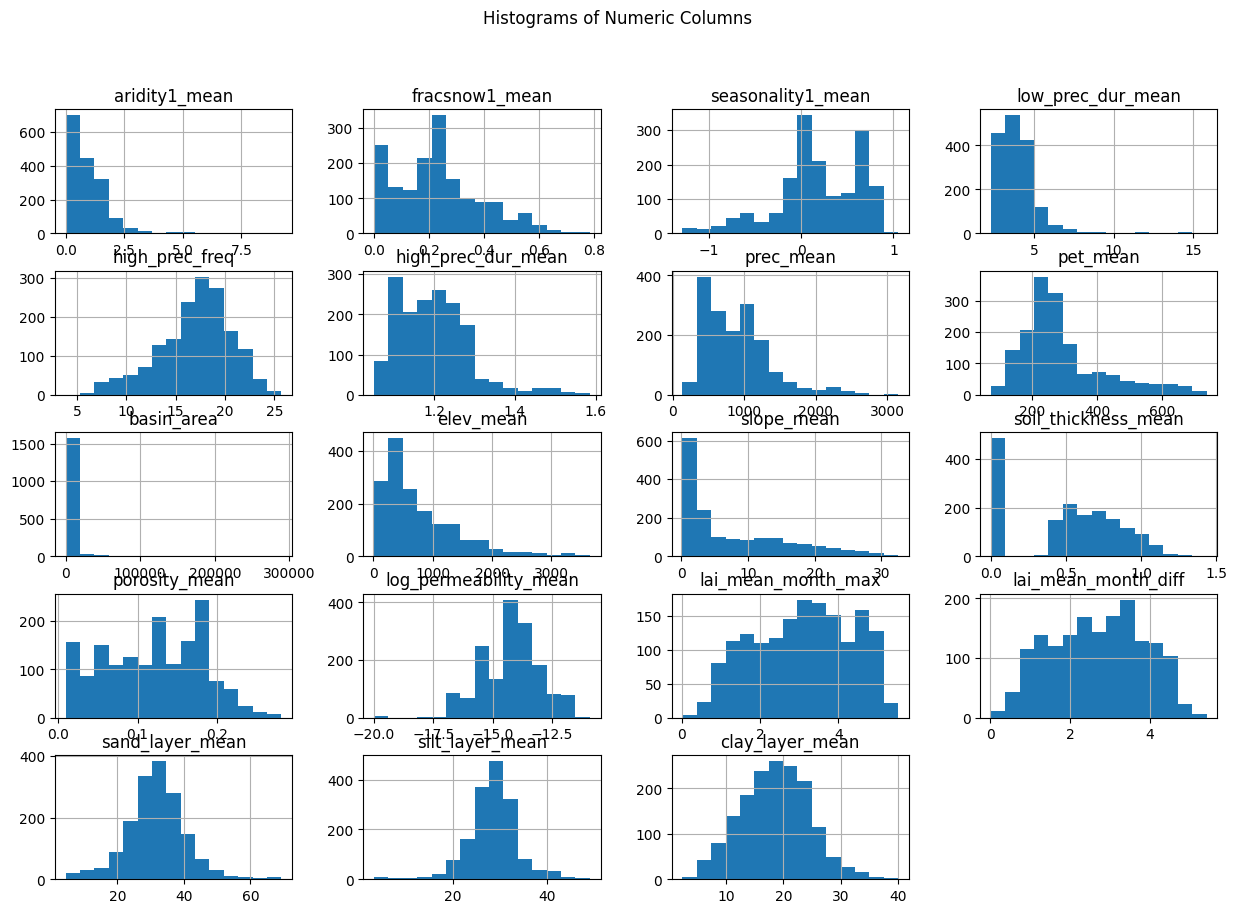

<Figure size 1500x1000 with 0 Axes>

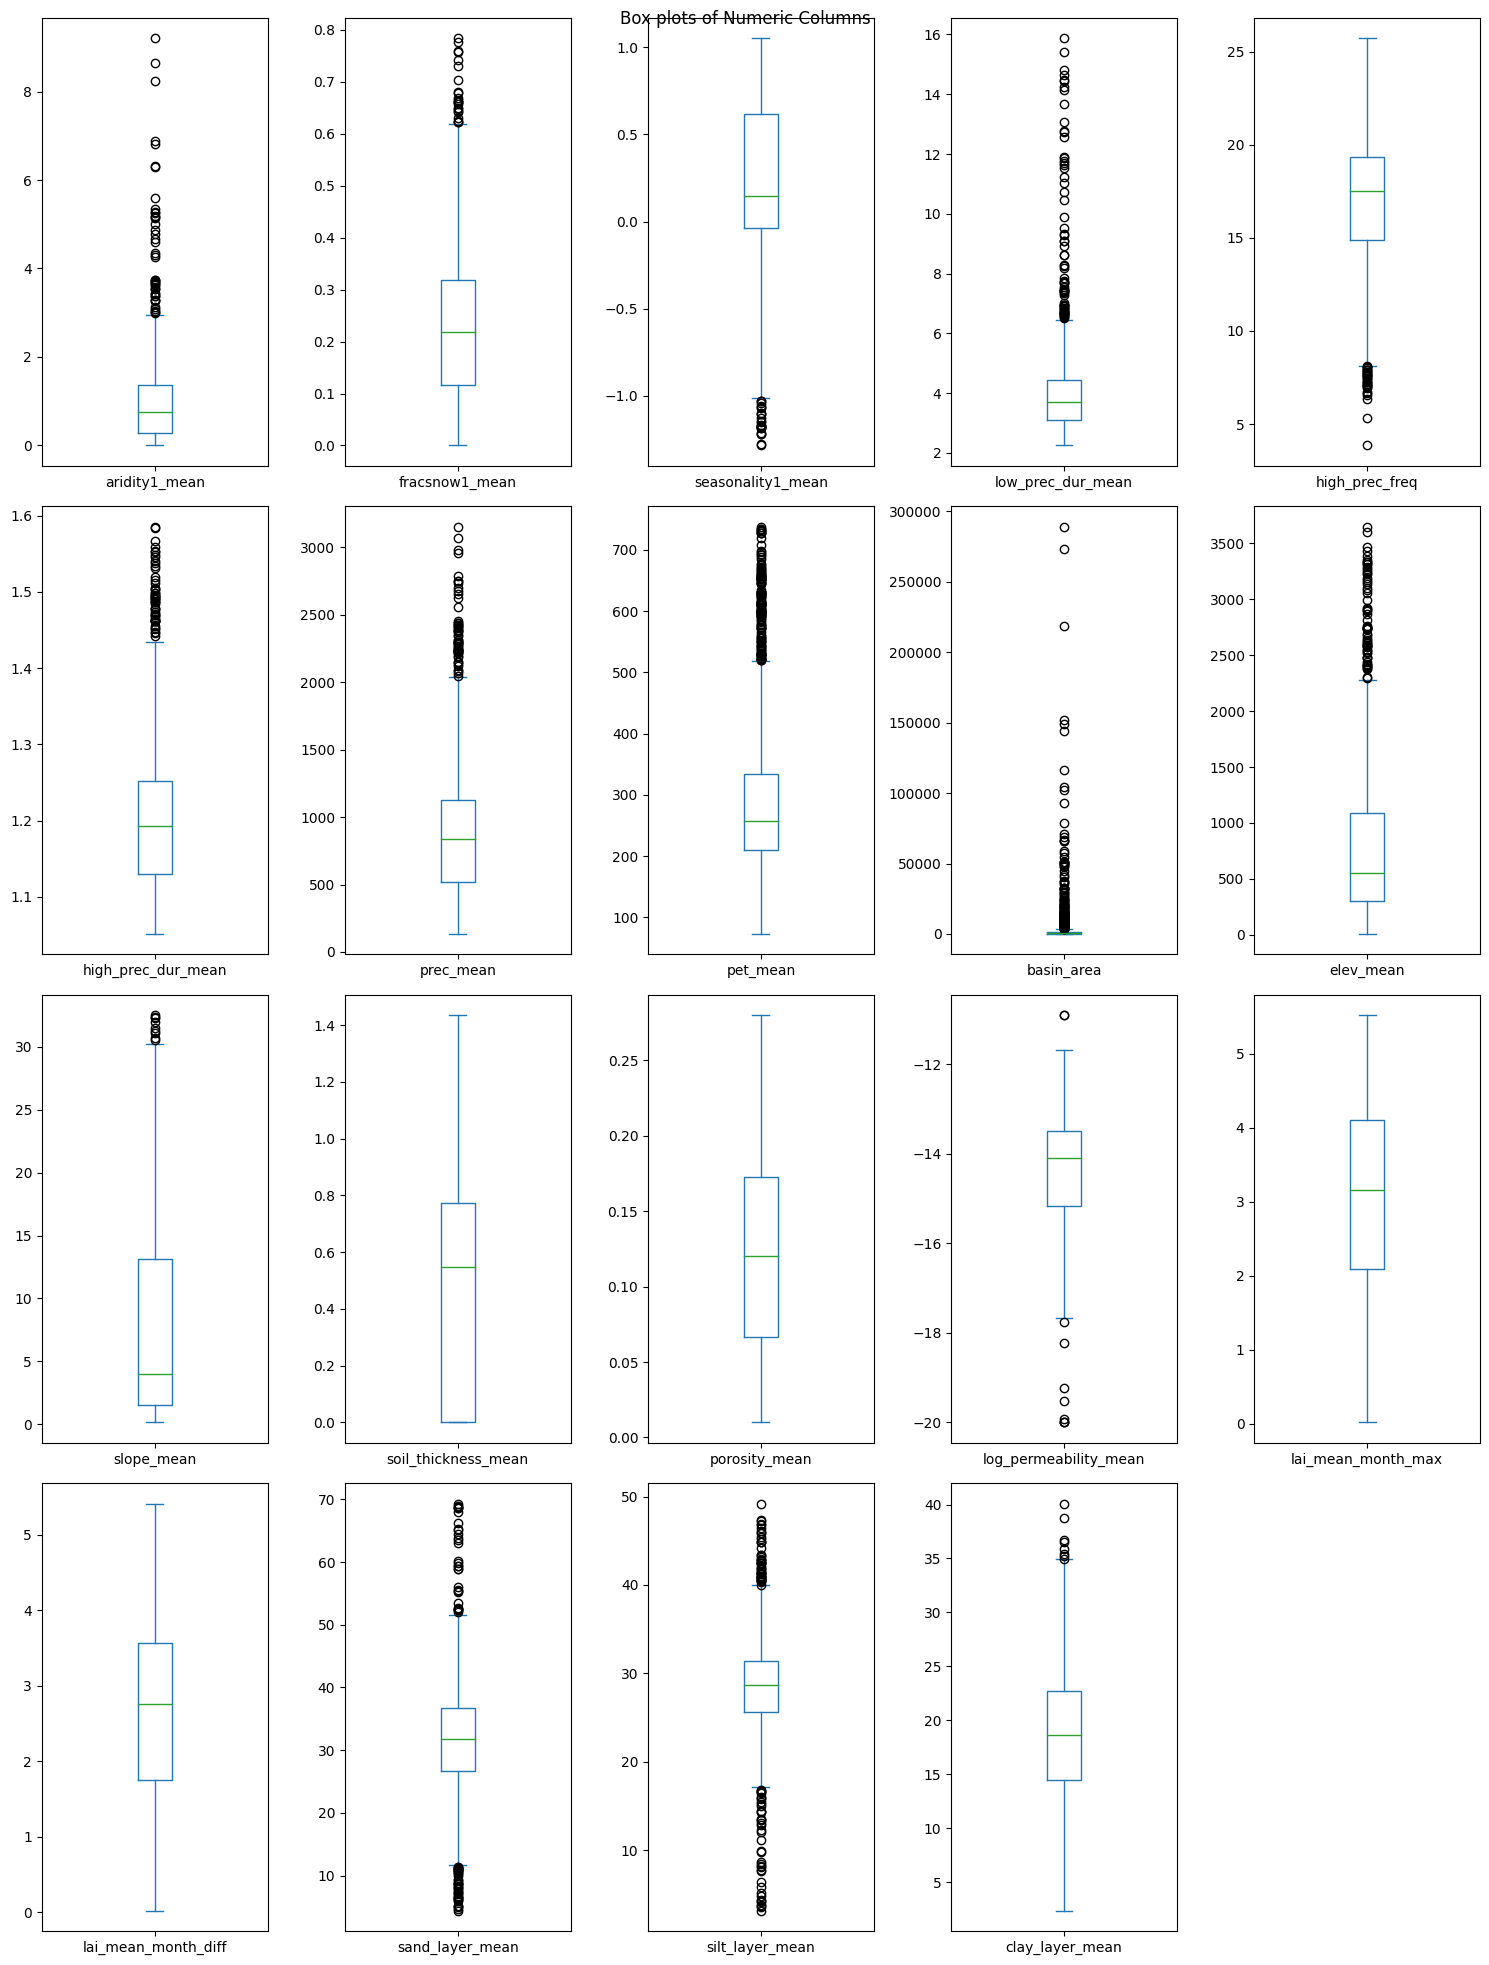

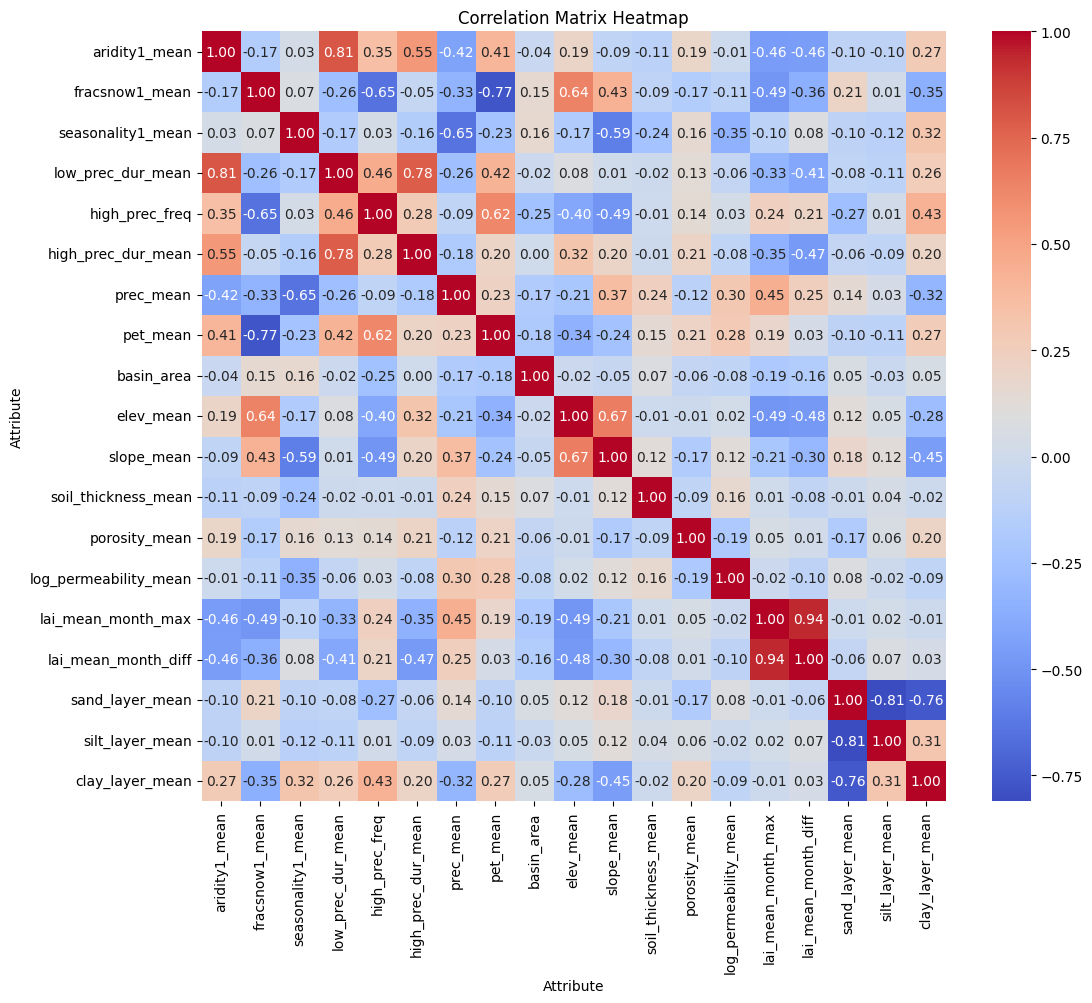

In [23]:
# Check for missing values
missing_values = attrs_df_nhT.isnull().sum()
missing_values_summary = missing_values[missing_values > 0]

print("Missing Values Summary:\n", missing_values_summary)

# Save the missing values summary to a file
missing_values_summary.to_csv('missing_values_summary.csv', index=True)

## Distributions

In [20]:
# Convert appropriate columns to float
columns_to_convert = ['aridity1_mean', 'fracsnow1_mean', 'seasonality1_mean', 'low_prec_dur_mean', 'high_prec_freq', 
                      'high_prec_dur_mean', 'prec_mean', 'pet_mean', 'basin_area', 'elev_mean', 'slope_mean', 
                      'soil_thickness_mean', 'porosity_mean', 'log_permeability_mean', 'lai_mean_month_max', 
                      'lai_mean_month_diff', 'sand_layer_mean', 'silt_layer_mean', 'clay_layer_mean']

for column in columns_to_convert:
    attrs_df_nhT[column] = attrs_df_nhT[column].astype(float)

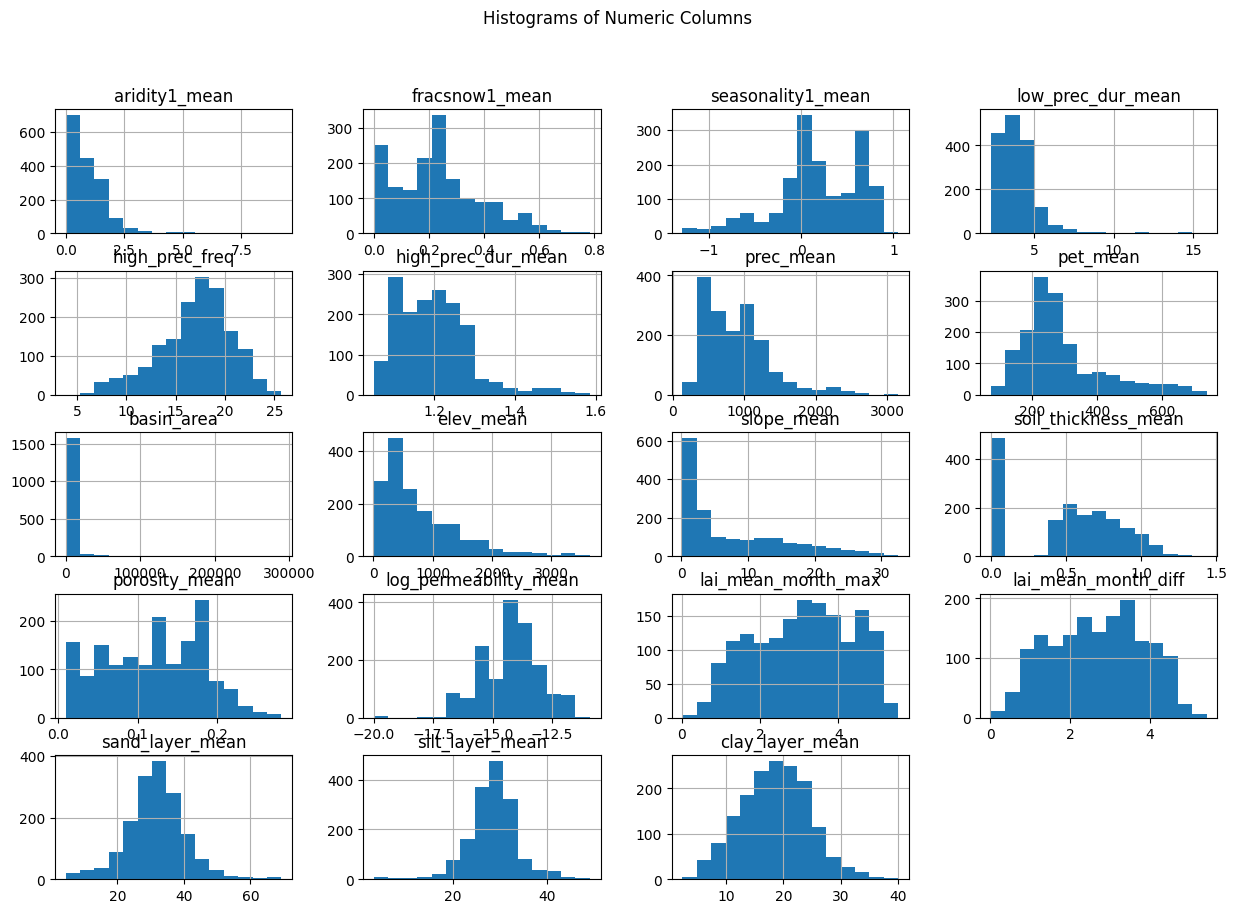

<Figure size 1500x1000 with 0 Axes>

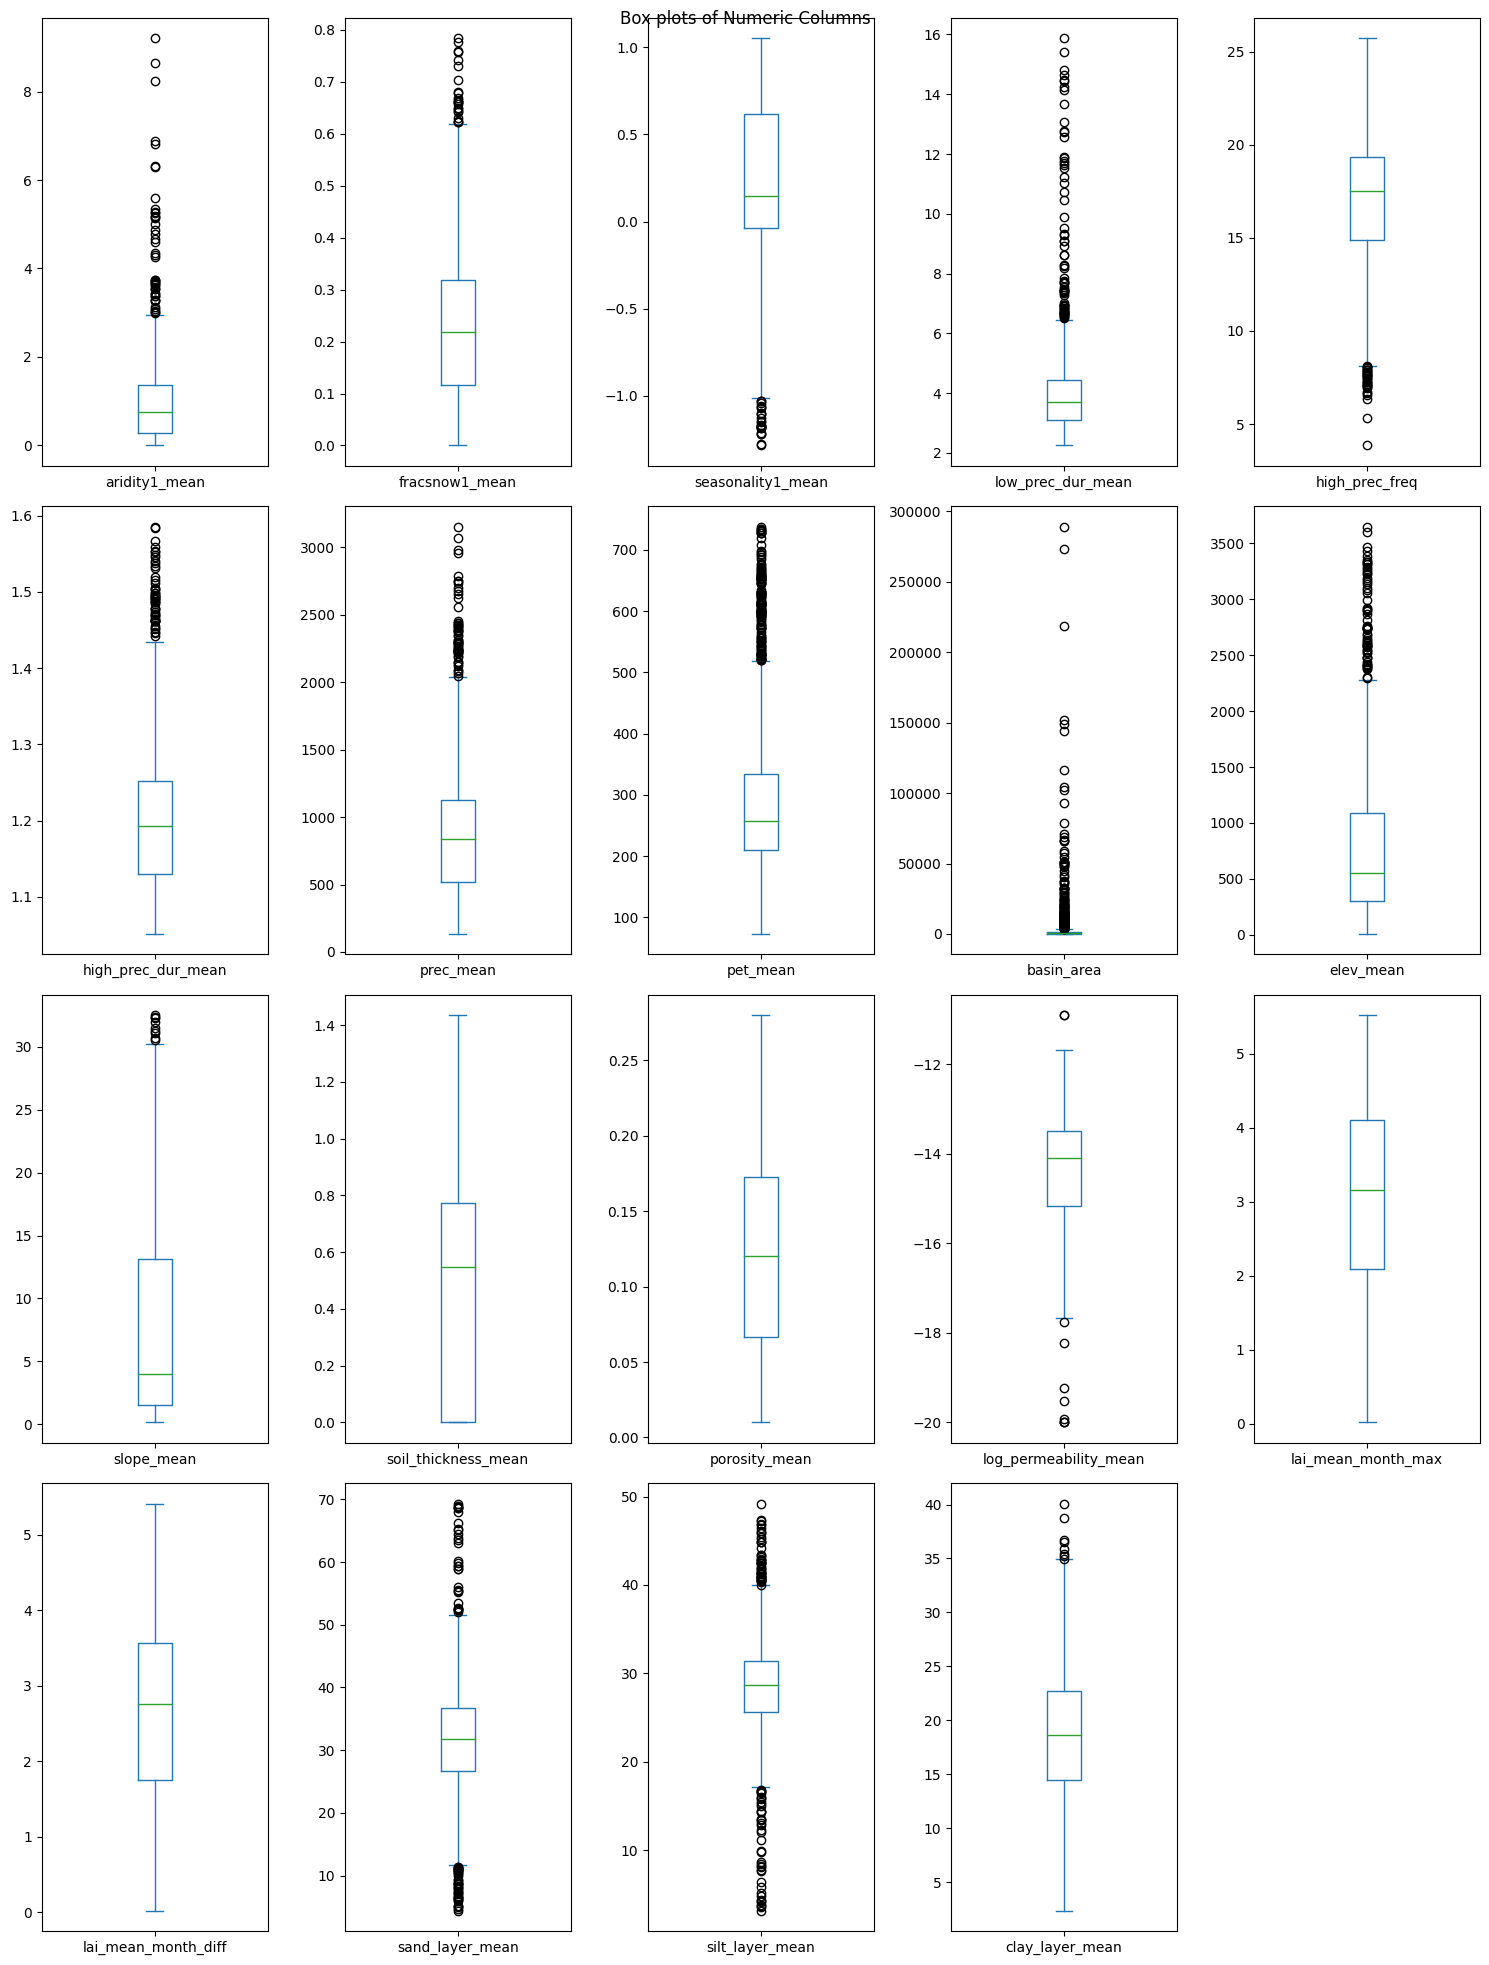

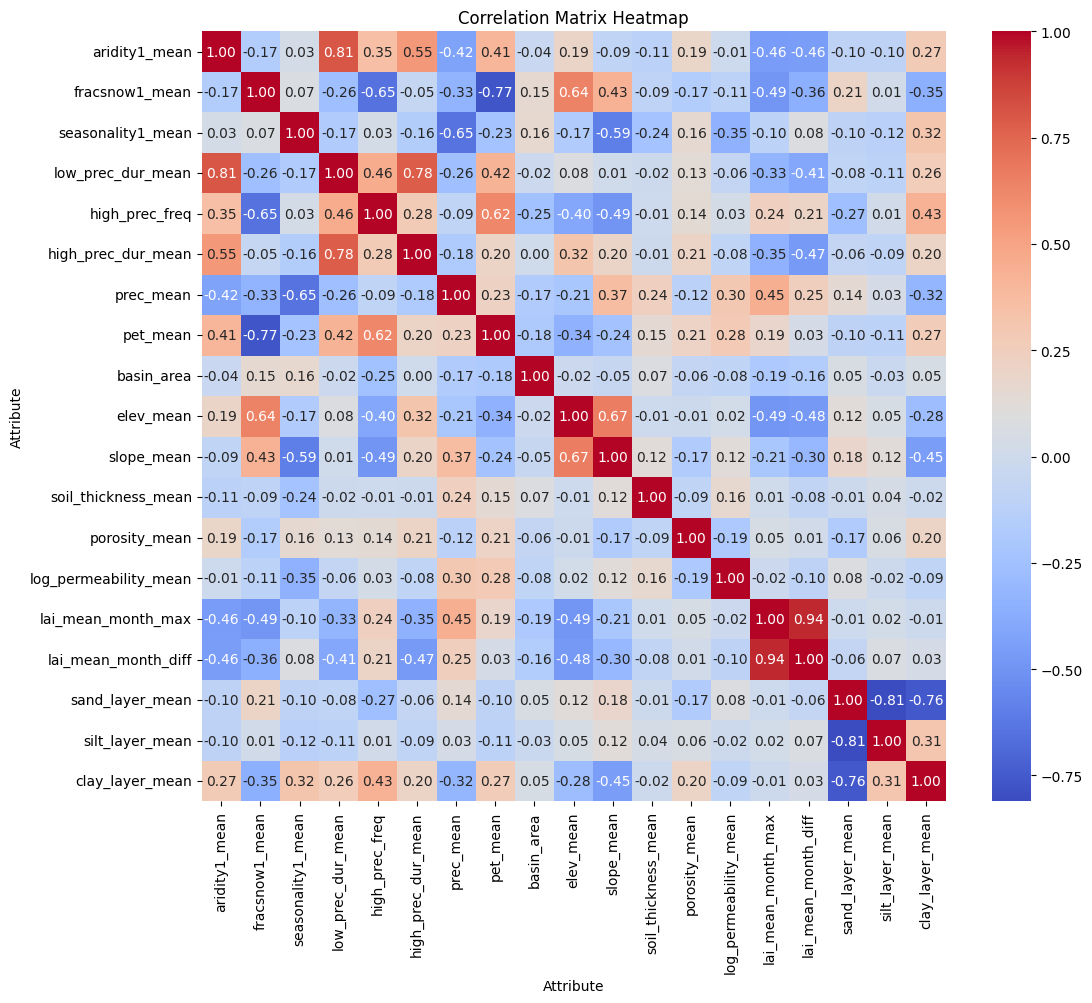

In [22]:
# Histograms for numeric columns
numeric_cols = attrs_df_nhT.select_dtypes(include=['float32', 'int32', 'float64', 'int64']).columns

attrs_df_nhT[numeric_cols].hist(bins=15, figsize=(15, 10))
plt.suptitle('Histograms of Numeric Columns')
plt.show()

# Box plots to identify outliers
plt.figure(figsize=(15, 10))
attrs_df_nhT[numeric_cols].plot(kind='box', subplots=True, layout=(4, 5), figsize=(15, 20), title='Box plots of Numeric Columns')
plt.tight_layout()
plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(attrs_df_nhT[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()